In [1]:
import tweetdf
import geopandas
import pandas
import trips
import odm
import sampers
import matplotlib.pyplot as plt
import matplotlib as mpl
import partition
import numpy as np
import odm_similarity
from shapely.geometry import Point
import importlib
importlib.reload(partition)
importlib.reload(odm_similarity)

<module 'odm_similarity' from '/Users/kristofferek/Documents/git/mscthesis/src/py/odm_similarity.py'>

In [2]:
region = 'west'
beta = 0.03

# Partition tweets into Samper's grid system

In this notebook we extract displacements from tweets in a region, and construct an ODM based on the grids used by Samper's model.

In [3]:
tweets = tweetdf.from_csv("./../../dbs/Sweden.csv")
tweets.shape

(1302359, 9)

1,3 Million geotagged tweets (by users with a detected home location in Sweden)

In [4]:
tweets = tweets.dropna()
tweets.shape

(1302358, 9)

## Extract displacements
Currently, we consider two consecutive stays to be a displacement if and only if the time between them is less than 12 hours.

In [6]:
displacements = trips.from_dfs(tweets)
displacements.shape

(554716, 10)

Construct ODM without aggregation into zones (based on lat/long)

In [7]:
latlngodm = odm.from_trips(displacements)
latlngodm.head()

,latitude_o,longitude_o,latitude_d,longitude_d,count
0,-79.898133,-49.192753,59.350000,18.066667,1
1,-54.809017,-68.302105,-54.808049,-68.307551,1
2,-54.808219,-68.318154,-54.809017,-68.302105,1
3,-54.808049,-68.307551,-54.783803,-68.259351,1
4,-54.805765,-68.307080,-54.783803,-68.259351,1


In [8]:
shp = sampers.read_shp(sampers.shps[region])
shp.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The above dataset defines the zones used by Samper's model.

Low resolution shape of sweden.

In [9]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

## ODM construction
Aggregate displacements into origin and destination zones from Samper's model.

In [10]:
odm_twitter_df = partition.convert_to_zones(latlngodm, sweden, shp)
odm_twitter_df

,ozone,dzone,count
0,831501,831501,2
1,831501,838415,1
2,831501,971804,1
3,831501,976651,1
4,831502,831502,4
...,...,...,...
19702,995844,994826,1
19703,995844,995142,5
19704,995844,995806,13
19705,995844,995814,4


In [11]:
zones_to_index = odm_similarity.shape_to_zone_dictionary(shp)

### Convert dataframe to OD matrix

In [12]:
odm_twitter_mat = odm_similarity.od_df_to_od_matrix(odm_twitter_df, zones_to_index, 'count')
odm_twitter_mat.shape

(2964, 2964)

### Load data from Samper's and place in OD matrix.

In [13]:
odm_sampers_df = sampers.read_odm(sampers.odms[region])
odm_sampers_mat = odm_similarity.od_df_to_od_matrix(odm_sampers_df, zones_to_index, 'total')
odm_sampers_mat.shape

(2964, 2964)

## Plot OD matrices

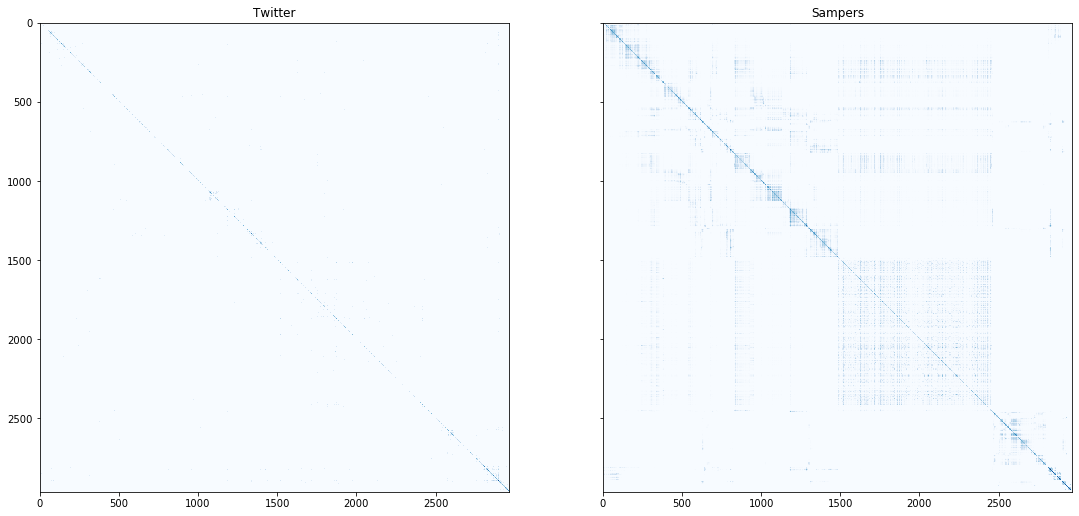

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(odm_twitter_mat, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=np.max(odm_twitter_mat)), cmap='Blues')
ax2.imshow(odm_sampers_mat, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=np.max(odm_sampers_mat)), cmap='Blues')
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()

In [17]:
importlib.reload(odm_similarity)
OD_gt, OD_tw, W, bins, hist, C1, C2 = odm_similarity.similarity(odm_sampers_df, odm_twitter_df, shp, region)

/Users/kristofferek/miniconda3/envs/mscthesis/lib/python3.8/site-packages/ipfn/ipfn.py:129: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m_ijk / ori_ijk - 1) > max_conv:


DONE: gravity model DF
DONE: gravity DF -> Matrix
DONE: GT DF -> Matrix
        ozone   dzone  count           d
0      831501  831501      2    0.000000
1      831501  838415      1   87.782314
2      831501  971804      1  398.044464
3      831501  976651      1   92.056239
4      831502  831502      4    0.000000
...       ...     ...    ...         ...
19702  995844  994826      1  317.289190
19703  995844  995142      5  203.229946
19704  995844  995806     13  142.879206
19705  995844  995814      4  210.288624
19706  995844  995844   1055    0.000000

[19707 rows x 4 columns]
DONE: Add distances to gravity DF
DONE: bins for SpSSIM created
DONE: Normalize GT matrix
DONE: Normalize Gravity matrix


In [ ]:
importlib.reload(odm_similarity)
SpSSIM_mean, SpSSIM_share_mean, df_comp = odm_similarity.OD2simi(OD_gt, OD_tw, W, bins, hist, C1, C2)
print("Similarity:", SpSSIM_mean, "Similarity weighted by travel demand:", SpSSIM_share_mean)
print("Similarity by distance group:\n", df_comp)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(OD_tw, norm = mpl.colors.LogNorm())
ax2.imshow(OD_gt, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()